<a href="https://colab.research.google.com/github/Faiz-Hibatullah/machine-learning-1103210172/blob/main/6.%20Week%206/Online_Retail_Data_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Load Data

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

# URL raw dataset
url = "https://github.com/farrelrassya/teachingMLDL/raw/main/01.%20Machine%20Learning/06.%20Week%206/Datasets/Online%20Retail.xlsx"

# Membaca dataset
df = pd.read_excel(url)

# Lihat beberapa baris data
df.head()

# Tampilkan informasi dataset
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    

#1. Preprocessing Data

In [9]:
# Hapus baris dengan CustomerID yang hilang dan Quantity negatif
df = df[df['CustomerID'].notnull()]
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]

# Buat fitur TotalAmount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Agregasi data per customer: kita ambil total belanja dan jumlah transaksi (frequency)
customer_df = df.groupby('CustomerID').agg({
    'TotalAmount': 'sum',
    'InvoiceNo': 'nunique'  # jumlah transaksi unik per customer
}).reset_index()

customer_df.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)
customer_df.head()

,CustomerID,TotalAmount,Frequency
0,12346.0,77183.60,1
1,12347.0,4310.00,7
2,12348.0,1797.24,4
3,12349.0,1757.55,1
4,12350.0,334.40,1


#2. Membuat Model Clustering


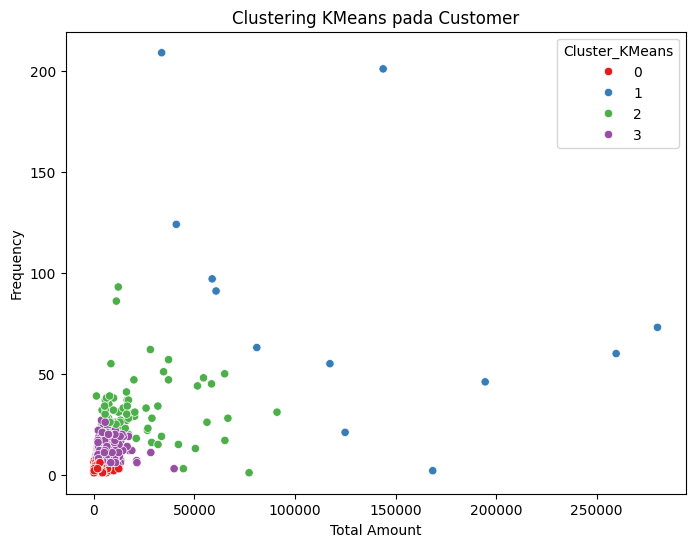

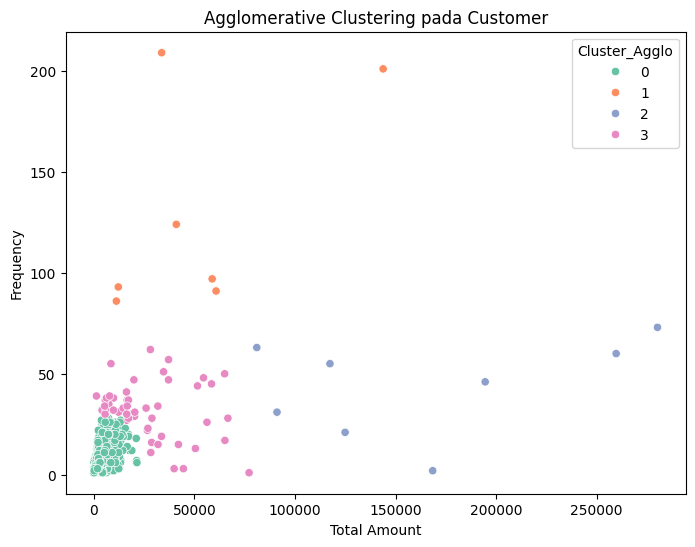

In [13]:
# Membuat model KMeans dengan jumlah cluster optimal
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
customer_df['Cluster_KMeans'] = kmeans.fit_predict(data_scaled)

# Visualisasi hasil clustering KMeans
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_df['TotalAmount'], y=customer_df['Frequency'],
                hue=customer_df['Cluster_KMeans'], palette='Set1')
plt.title("Clustering KMeans pada Customer")
plt.xlabel("Total Amount")
plt.ylabel("Frequency")
plt.show()

# Membuat model Agglomerative Clustering dengan jumlah cluster optimal
agglo = AgglomerativeClustering(n_clusters=k_optimal)
customer_df['Cluster_Agglo'] = agglo.fit_predict(data_scaled)

# Visualisasi hasil Agglomerative Clustering
plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_df['TotalAmount'], y=customer_df['Frequency'],
                hue=customer_df['Cluster_Agglo'], palette='Set2')
plt.title("Agglomerative Clustering pada Customer")
plt.xlabel("Total Amount")
plt.ylabel("Frequency")
plt.show()


#3. Menghhitung Matriks Cluster

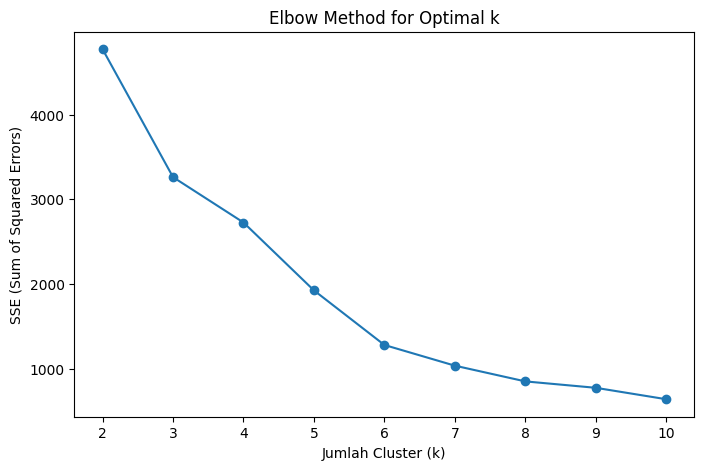

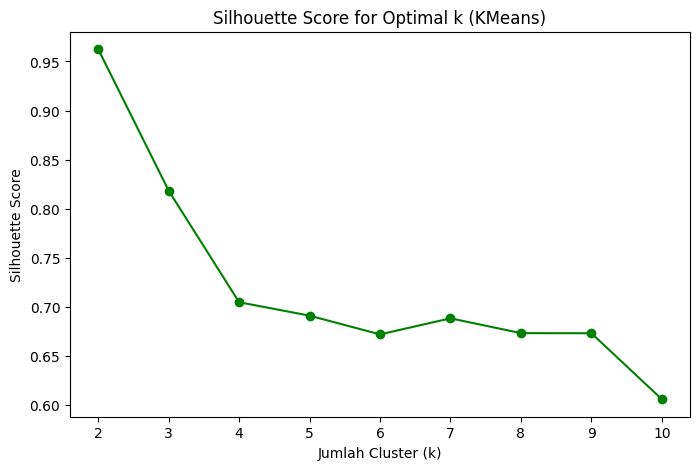

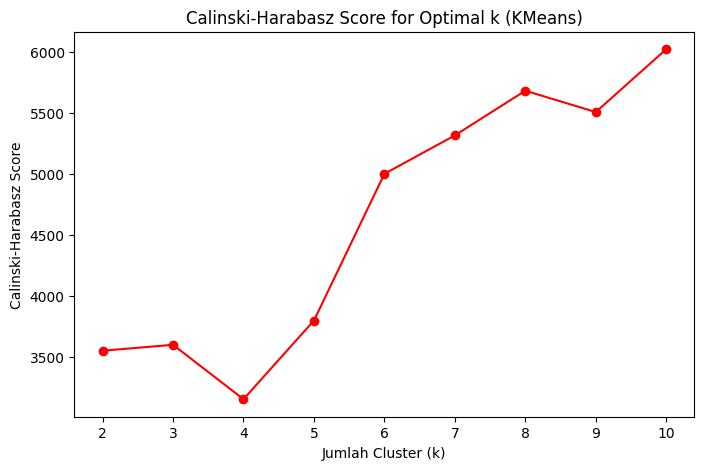

Dunn Index (KMeans, k=4): 3.1955749118071314e-05


In [15]:
from sklearn.preprocessing import StandardScaler

features = ['TotalAmount', 'Frequency']
scaler = StandardScaler()
data_scaled = scaler.fit_transform(customer_df[features])

# Mencari jumlah cluster optimal menggunakan Elbow Method pada KMeans
sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)  # inertia_ adalah jumlah jarak kuadrat dalam cluster

plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("SSE (Sum of Squared Errors)")
plt.show()

# Evaluasi dengan Silhouette Score untuk menentukan jumlah cluster optimal
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score for Optimal k (KMeans)")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Silhouette Score")
plt.show()

calinski_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = calinski_harabasz_score(data_scaled, labels)
    calinski_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(k_range, calinski_scores, marker='o', color='red')
plt.title("Calinski-Harabasz Score for Optimal k (KMeans)")
plt.xlabel("Jumlah Cluster (k)")
plt.ylabel("Calinski-Harabasz Score")
plt.show()

from scipy.spatial.distance import euclidean

def compute_dunn_index(points, labels):
    unique_cluster = np.unique(labels)
    n_clusters = len(unique_cluster)

    # Membuat dictionary untuk menyimpan indeks dari masing-masing cluster
    clusters = {cl: points[labels == cl] for cl in unique_cluster}

    # Hitung jarak minimum antar cluster
    min_intercluster = np.inf
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            cluster_i = clusters[unique_cluster[i]]
            cluster_j = clusters[unique_cluster[j]]
            # hitung jarak antar semua pasangan titik antar cluster i dan j
            distances = np.array([euclidean(x, y) for x in cluster_i for y in cluster_j])
            min_intercluster = min(min_intercluster, distances.min())

    # Hitung diameter setiap cluster (jarak maksimum dalam cluster)
    max_intracluster = 0
    for cl in unique_cluster:
        cluster_points = clusters[cl]
        if len(cluster_points) > 1:
            distances = cdist(cluster_points, cluster_points, metric='euclidean')
            diameter = distances.max()
            max_intracluster = max(max_intracluster, diameter)

    return min_intercluster / max_intracluster if max_intracluster > 0 else np.nan

# Menghitung Dunn index untuk KMeans dengan k=4 (misalnya, hasil dari evaluasi sebelumnya)
k_optimal = 4
kmeans_model = KMeans(n_clusters=k_optimal, random_state=42)
labels_kmeans = kmeans_model.fit_predict(data_scaled)
dunn_index = compute_dunn_index(data_scaled, labels_kmeans)
print("Dunn Index (KMeans, k=4):", dunn_index)




# Evaluasi Clustering

## 1. Elbow Methode (SSE)
 Elbow method menghitung nilai inertia untuk berbagai jumlah cluster. Inertia adalah jumlah kuadrat jarak Euclidean antara setiap titik dengan pusat cluster-nya.

Fungsi objektif dalam KMeans didefinisikan sebagai:

$$
\text{Inertia} = \sum_{k=1}^{K} \sum_{x_i \in C_k} \|x_i - \mu_k\|^2
$$

- $(K)$ : jumlah cluster  
- $(C_k)$ : himpunan titik pada cluster ke-\(k\)  
- $(\mu_k)$ : pusat (mean) dari cluster ke-\(k\)

Titik "elbow" yang ditunjukkan pada grafik menunjukkan jumlah cluster yang optimal.

---

## 2. Silhouette Coefficient

Silhouette coefficient mengukur seberapa mirip setiap titik dengan cluster-nya dibandingkan dengan cluster lain. Untuk setiap data $(i)$:

$$
s(i) = \frac{b(i) - a(i)}{\max \{ a(i), b(i) \}}
$$


- **$a(i)$**: jarak rata-rata dari titik $i$ ke semua titik lain dalam cluster yang sama (intra-cluster distance),  
- **$b(i)$**: jarak rata-rata dari titik $i$ ke semua titik pada cluster terdekat yang berbeda (nearest-cluster distance).

Nilai $s(i)$ berkisar dari -1 (cluster yang tidak sesuai) hingga +1 (cluster yang sangat kompak).

Nilai rata-rata silhouette mendekati 1 menunjukkan pemisahan cluster yang baik.

Kelebihan: mudah diinterpretasi dan memberikan insight per titik.

---

## 3. Calinski-Harabasz Index

Indeks ini mengukur seberapa baik cluster yang terbentuk dengan menghitung rasio variansi antar cluster terhadap variansi dalam cluster:

$$
CH = \frac{\text{Between-Cluster Dispersion}}{\text{Within-Cluster Dispersion}} \times \frac{N - k}{k - 1}
$$

- **$N$**: jumlah total data,  
- **$k$**: jumlah cluster,  
- **Between-Cluster Dispersion**: mengukur jarak antar centroid cluster,  
- **Within-Cluster Dispersion**: mengukur jarak antara titik data dengan centroid cluster masing-masing.

---

## 4. Dunn Index

Dunn Index mendefinisikan kualitas clustering dengan mengambil rasio antara jarak antar cluster minimum dan diameter maksimal di antara setiap cluster:

$$
\text{Dunn} = \frac{\min_{i \neq j} \; \delta(C_i,C_j)}{\max_{1 \leq k \leq K} \; \Delta(C_k)}
$$

- **$\delta(C_i,C_j)$**: jarak minimum antara tiap titik dari cluster $C_i$ dengan tiap titik dari cluster $C_j$,  
- **$\Delta(C_k)$**: diameter cluster $C_k$, yakni jarak maksimum antara dua titik dalam cluster yang sama.

Nilai Dunn Index yang besar menandakan adanya pemisahan antar cluster yang baik dan cluster yang kompak.

---

Metriks Terbaik:
- Elbow Method membantu menentukan jumlah cluster dengan menganalisis perubahan inertia, namun kurang eksplisit dalam memberi batasan untuk cluster yang “baik”.

- Silhouette Coefficient sangat populer karena mengkombinasikan informasi intra- dan inter-cluster serta mudah diinterpretasi.

- Calinski-Harabasz Index juga banyak digunakan karena sederhana dan cepat.

- Dunn Index memberikan gambaran yang sangat jelas mengenai pemisahan dan kompaksi cluster, tetapi terkadang sulit untuk dihitung pada dataset besar.

Dalam praktiknya, Silhouette Coefficient sering dijadikan patokan karena memberikan nilai yang relatif mudah dipahami, sementara Calinski-Harabasz Index bisa dipakai sebagai konfirmasi tambahan.

